In [1]:
# import librabries
import sqlite3
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud

import numpy as np
import re
import matplotlib.pyplot as plt



In [2]:
#Connect to the database
con = sqlite3.connect(r"C:\Users\20211090\OneDrive\Desktop\database.db")

query_klm = '''
    SELECT text
    FROM KLM_tweets 
'''
df_klm = pd.read_sql_query(query_klm, con)


df_klm.head(5)

#cursor = con.cursor()
#cursor.execute(query_klm)

#for row in cursor:
#   print ("text = " + row[0])

,text
0,@Pelusitaaaa1 Hoi! Enkel KLM/Air France-vluch...
1,@Pelusitaaaa1 We helpen je graag. Kan je ons e...
2,@addblackman We understand that you would pref...
3,@CarlosMosig Con el fin de evitar errores noso...
4,@addblackman We do understand that some passen...


In [3]:
# cleaning text

# define a function to prepocess the text (for KLM). 
def preproc_text(text):
    text = re.sub(r'@[^\s]+','',text) #remove quote
    text = re.sub(r'RT[\s]+',' ',text) #remove retweet
    text = re.sub(r'http\S+',' ',text) #remove hyperlink
    text = re.sub(r'www.\S+','',text) # remove web link
    text = re.sub(r'#[A-Za-z0-9_]+','',text) # remove hashtag
    text = re.sub(r'[()!?]','',text) #remove exlamation marks
    
    text = text.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    text = [word for word in text if not word in stopwords] #remove stopwords
    text = ' '.join(word for word in text)
    return text
  
df_klm['text'] = df_klm['text'].apply(preproc_text)

In [4]:
df_klm


,text
0,Hoi Enkel KLM/Air France-vluchten vluchten met...
1,We helpen je graag. Kan je ons een DM sturen z...
2,We understand that you would prefer have your ...
3,Con el fin de evitar errores nosotros volvemos...
4,We do understand that some passengers do not l...
...,...
5017,Ã‚Â¡Ya vamos para Calella para hacer la activi...
5018,Home Royal Dutch Airlines
5019,Hij vliegt toch wel op windenergie mag ik hope...
5020,V-shaped Flying Wing concept by uses two engin...


In [5]:
# define a function to get subjectivity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity # how subjectivity the opinion is

# define a function to get polarities

def get_polarity(text):
    return TextBlob(text).sentiment.polarity # how positive or negative is the text

df_klm['subjectivity'] = df_klm['text'].apply(get_subjectivity)
df_klm['polarity'] = df_klm['text'].apply(get_polarity)

In [6]:
#define a function to analyze the score to levels
def analysis(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_klm['analysis'] = df_klm['polarity'].apply(analysis)


df_klm

,text,subjectivity,polarity,analysis
0,Hoi Enkel KLM/Air France-vluchten vluchten met...,0.000000,0.000000,Neutral
1,We helpen je graag. Kan je ons een DM sturen z...,0.000000,0.000000,Neutral
2,We understand that you would prefer have your ...,0.000000,0.000000,Neutral
3,Con el fin de evitar errores nosotros volvemos...,0.000000,0.000000,Neutral
4,We do understand that some passengers do not l...,0.291667,0.000000,Neutral
...,...,...,...,...
5017,Ã‚Â¡Ya vamos para Calella para hacer la activi...,0.000000,0.000000,Neutral
5018,Home Royal Dutch Airlines,0.000000,0.000000,Neutral
5019,Hij vliegt toch wel op windenergie mag ik hope...,0.000000,0.000000,Neutral
5020,V-shaped Flying Wing concept by uses two engin...,0.066667,-0.166667,Negative


Text(0, 0.5, 'subjectivity')

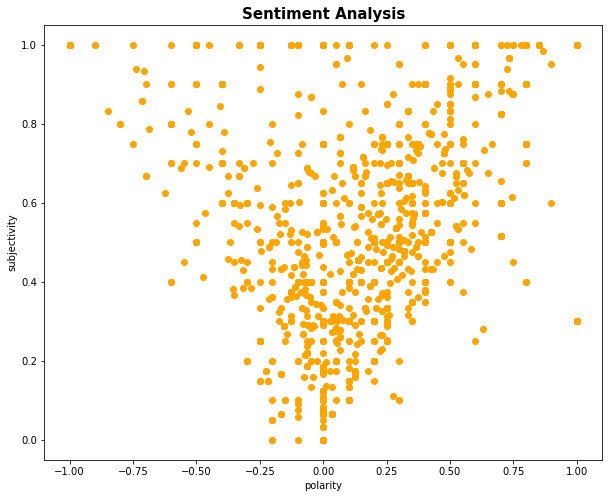

In [7]:
# plot subj and polarity
plt.figure( figsize =(10,8))
for i in range(0, df_klm.shape[0]):
    plt.scatter(df_klm['polarity'][i],df_klm['subjectivity'][i], color = 'orange')
plt.title('Sentiment Analysis', fontsize= 15, fontweight='bold')
plt.xlabel('polarity')
plt.ylabel('subjectivity')

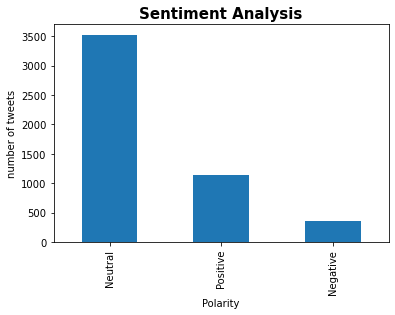

In [8]:
# Sentiment Distribution Plot

plt.title('Sentiment Analysis', fontsize= 15, fontweight='bold')
plt.xlabel('Polarity')
plt.ylabel('number of tweets')
df_klm['analysis'].value_counts().plot(kind ='bar')
plt.show()

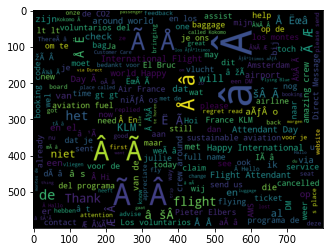

In [9]:

#textcloud visualization to get key-words

words = ' '.join([text for text in df_klm['text']])
text_cloud = WordCloud( width = 800, height = 600, random_state = 22, max_font_size = 120).generate(words)
plt.imshow(text_cloud)
plt.show()